## Utility code

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob
import subprocess
import re

import geopandas
#from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(style="darkgrid")

Set paths

In [2]:

#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/myriadOutputs/"
path = "/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/ICCS/all/"
plot_path = "/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/plots/"


In [3]:
def plotMetric(files, prefix, metrics = [], symbol = "-", alpha=1, weighting = 1, label= "", days=30):
    myAvgLine = []
    index = 0
    template = "^" + prefix + "*"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data_raw = pd.read_csv(path + f, sep='\t')
            r_data_raw = r_data_raw[r_data_raw['time'] < days]
            
            #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
            unique_dist_names = pd.unique(r_data_raw['myId'])
            if len(unique_dist_names) == 1:
                r_data = r_data_raw
            else:
                r_data = r_data_raw.groupby('time', as_index=False).agg({'metric_died_count': 'sum', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})
            totcases = []
            for metric in metrics:
                if len(totcases) == 0:
                    totcases = r_data[metric]
                else:        
                    totcases = totcases + r_data[metric]
            #totcases = r_data[metric]
            
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], weighting * totcases[1:], symbol, alpha=alpha, label=label)
            index += 1
    if index <= 1:
        return {}
    else:
        return {"myLine": weighting * myAvgLine/index, "myTime": r_data["time"]}

In [4]:
def readInScenario(files, prefix, lowerTimeLimit = -1, upperTimeLimit = 1000000):

    template = "^" + prefix + "*"

    myData = None
    
    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data_raw = pd.read_csv(path + f, sep='\t')

            r_data_raw = r_data_raw[r_data_raw['time'] < upperTimeLimit]
            r_data_raw = r_data_raw[r_data_raw['time'] > lowerTimeLimit]

            #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
            unique_dist_names = pd.unique(r_data_raw['myId'])
            if len(unique_dist_names) == 1:
                r_data = r_data_raw
            else:
                r_data = r_data_raw.groupby('myId', as_index=False).agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})

            r_data['district'] = [int(x.split('_')[1]) for x in r_data['myId']]
            r_data['seed'] = f.split("_")[-1]
            
            if myData is None:
                myData = r_data
            else:
                myData = myData.append(r_data)
                
    return myData

In [5]:
# testing to make sure I know how to append dataframes
d = {'col1': [1, 2], 'col2': [3, 4]}
e = {'col1': [5, 6], 'col2': [7, 8]}
df = pd.DataFrame(data=d)
df2 = pd.DataFrame(data=e)
df.append(df2)
df

,col1,col2
0,1,3
1,2,4


In [6]:
def plotMapAtTime(file, geoDf, geoDfColname="ID_2", weighting=1, days=30): # add time cutoff -how many days?

    r_data_raw = pd.read_csv(file, sep='\t')
    #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
    unique_dist_names = pd.unique(r_data_raw['myId'])
    r_data_raw = r_data_raw[r_data_raw["time"] < days]
    
    if len(unique_dist_names) == 1:
        return
    else:
        r_data = r_data_raw.groupby('myId', as_index=False).agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})

        distNum = [int(x.split('_')[1]) for x in r_data['myId']]
        r_data[geoDfColname] = distNum
        #print(r_data.head())
        #print(geoDf.head())
        for i in ['metric_died_count', 'metric_new_hospitalized', 'metric_new_critical',
                  'metric_new_cases_asympt', 'metric_new_cases_sympt',
                  'metric_new_deaths', 'metric_new_recovered', 'metric_currently_infected']:
            r_data[i] = r_data[i] * weighting

        joined = geoDf.join(r_data.set_index(geoDfColname), on=geoDfColname)
        return joined


In [7]:
def plotMapAtTimeFromDF(df, geoDf, geoDfColname="ID_1", weighting=1, days=30): # add time cutoff -how many days?

    #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
    unique_dist_names = pd.unique(df['myId'])
    df_raw = df[df["time"] < days]
    
    if len(unique_dist_names) == 1:
        return
    else:
        r_data = df_raw.groupby('myId', as_index=False).agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})

        distNum = [int(x.split('_')[1]) for x in r_data['myId']]
        r_data[geoDfColname] = distNum
        #print(r_data.head())
        #print(geoDf.head())
        for i in ['metric_died_count', 'metric_new_hospitalized', 'metric_new_critical',
                  'metric_new_cases_asympt', 'metric_new_cases_sympt',
                  'metric_new_deaths', 'metric_new_recovered', 'metric_currently_infected']:
            r_data[i] = r_data[i] * weighting

        return joined


In [8]:

files = os.listdir(path)

v3Files_25 = []
v3Files_5 = []

for f in files:
    if f.find("25p_v3") > 0:
        v3Files_25.append(f)
    elif f.find("_5p_v3") > 0:
        v3Files_5.append(f)

In [9]:
# testing an example

prefix = "myriad_test_agg_5p_v3_" # _v1
x = readInScenario(files, prefix)
x['district'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59,  6, 60,  7,  8,  9])

## Plot the overall numbers


### Line chart comparison of all three scenarios with same seed on same graph - m1, v1, v3 deaths


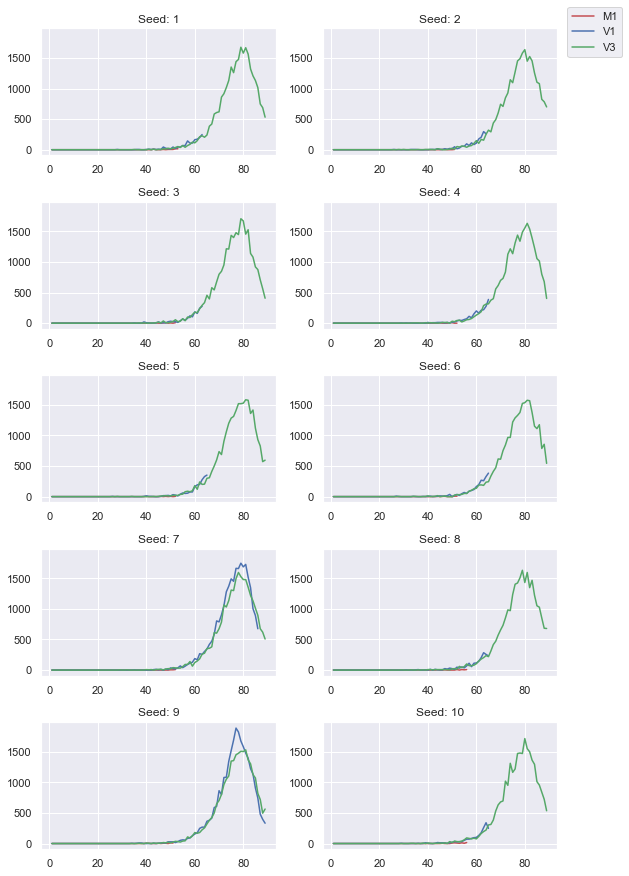

In [10]:
# the prefixes to specify each scenario
prefix_m1 = "myriad_test_agg_25p_m1_0.3_"
prefix_v1 = "myriad_test_agg_25p_v1_0.3_"
prefix_v3 = "myriad_test_agg_25p_v3_0.3_"
weight = 4

# set up the figure

fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(8, 24) # change the plot size
sns.set(font_scale=1) # change the font size

# set up the axis holder
axlast = -1

# iterate over each seed and plot it separately
for i in range(10):
    
    # plot relative to the last axis (if that exists)
    if axlast == -1:
        axlast = plt.subplot(10, 2, i+1)
    else:
        axlast = plt.subplot(10, 2, i+1, sharey=axlast)
        
    # specify the name of this file
    subfix = str(i + 1) + ".tx"

    # plot the specific scenarios for each with the appropriate color
    plotMetric(files, prefix_m1 + subfix, ["metric_new_deaths"], 'r', 1, weight, "M1", days=90)
    plotMetric(files, prefix_v1 + subfix, ["metric_new_deaths"], 'b', 1, weight, "V1", days=90)
    plotMetric(files, prefix_v3 + subfix, ["metric_new_deaths"], 'g', 1, weight, "V3", days=90)

    # title the subplot
    plt.title("Seed: " + str(i+1))

# create the legend
lines, labels = axlast.get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(1.1, 1))

# modify the layout
plt.tight_layout()

# save the figure
fig.savefig(plot_path + "deathRates_25perc_comparisonBySeed.png", dpi=300)

### 4 panels: cases in the first 30, 60, 90 days (averages? One case study?)

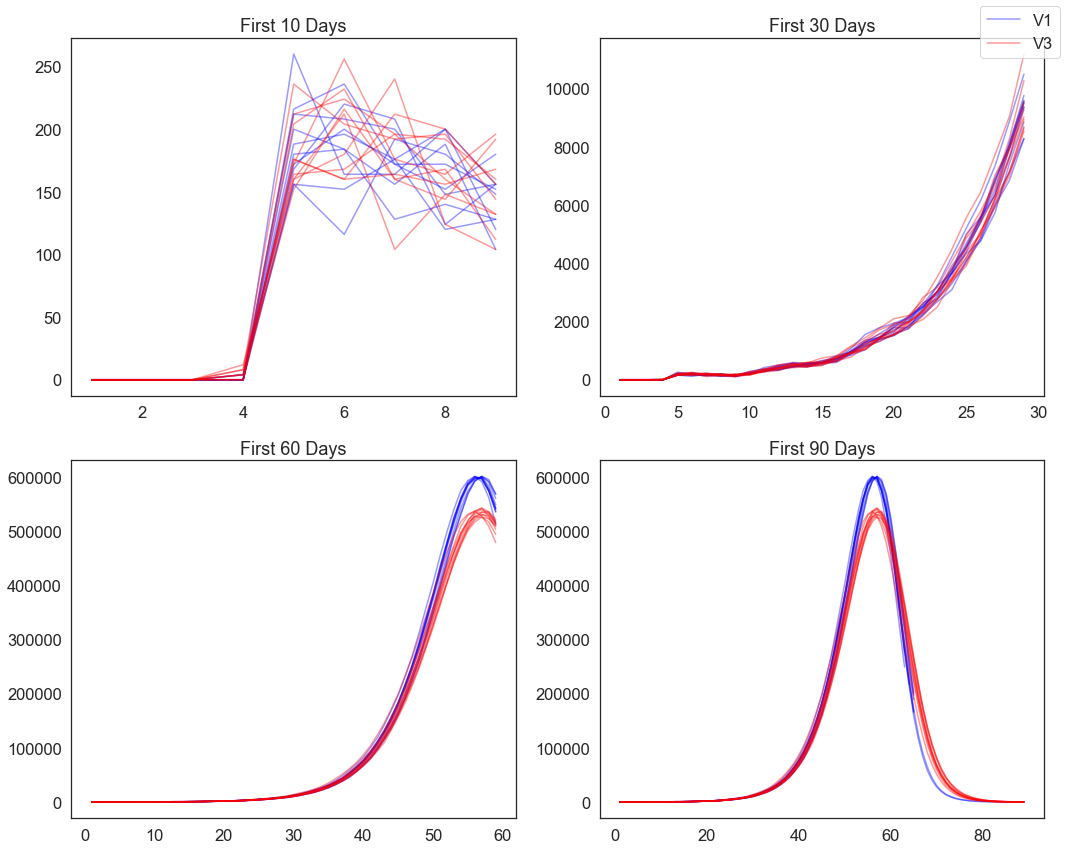

In [11]:
# the prefixes to specify each scenario
prefix_m1 = "myriad_test_agg_25p_m1_0.3_"
prefix_v1 = "myriad_test_agg_25p_v1_0.3_"
prefix_v3 = "myriad_test_agg_25p_v3_0.3_"
weight = 4

# set up the figure
fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 12) # change the plot size
sns.set(font_scale=1.5) # change the font size
sns.set_style(style='white')
sns.color_palette("Set2")


# the metrics
metrics = ["metric_new_cases_sympt", "metric_new_cases_asympt"]
alpha = .4
index = 1

axlast = []

# iterate over each seed and plot it separately
for i in [10, 30, 60, 90]:
    
    # plot!
    axlast = plt.subplot(2, 2, index)
    index += 1
        
    # plot the specific scenarios for each with the appropriate color
    #plotMetric(files, prefix_m1, metrics, 'r', alpha, weight, "M1", days=i)
    plotMetric(files, prefix_v1, metrics, 'blue', alpha, weight, "V1", days=i)
    plotMetric(files, prefix_v3, metrics, 'red', alpha, weight, "V3", days=i)
    
    # title the subplot
    plt.title("First " + str(i) + " Days")

# create the legend
lines, labels = axlast.get_legend_handles_labels()
lines = lines[::10]
labels = pd.unique(labels)

fig.legend(lines, labels, bbox_to_anchor=(1, 1))

# modify the layout
plt.tight_layout()

# save the figure
fig.savefig(plot_path + "caseRates_25perc_comparisonOverTime.png", dpi=300)

## Geographics

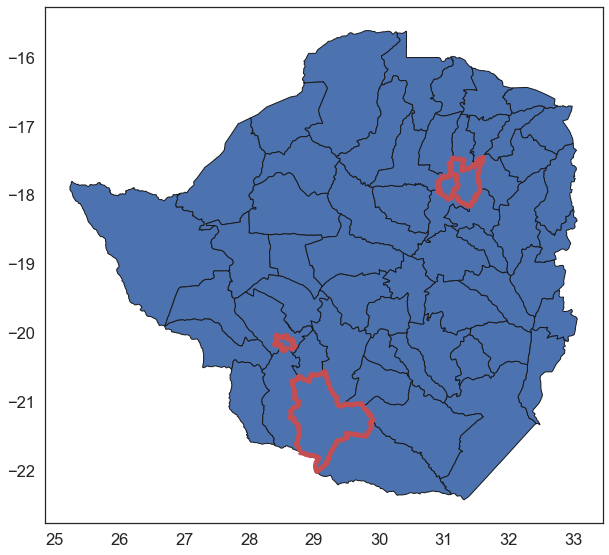

In [12]:
#zimFile = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp"
zimFile = "/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp"

zimbabwe = geopandas.read_file(zimFile)

#fig = plt.gcf() # extracting the figure information so we can change sizes
#fig.set_size_inches(15, 15) # change the plot size

ax = zimbabwe.plot(edgecolor='k', figsize=(10,10))
linelist = zimbabwe[zimbabwe["ID_2"].isin([1, 2, 18, 48])]
linelist.plot(ax=ax, edgecolor='r', linewidth=5)

fig.savefig(path + "linelist.png", dpi=300)

In [13]:
# the prefixes to specify each scenario
prefix_v3_5 = "myriad_test_agg_5p_v3_0.3_"
prefix_v3_25 = "myriad_test_agg_25p_v3_0.3_"


data_25 = readInScenario(files, prefix_v3_25)

data_25.head()

,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,district,seed
0,d_1,237,3659,776,48064,81682,237,128697,1319623,1,3.txt
1,d_10,72,821,208,12162,19816,72,31928,318609,10,3.txt
2,d_11,55,573,149,7863,12692,55,20810,197879,11,3.txt
3,d_12,138,1134,337,14306,23828,138,37891,385385,12,3.txt
4,d_13,90,1243,277,16835,28036,90,44853,450148,13,3.txt


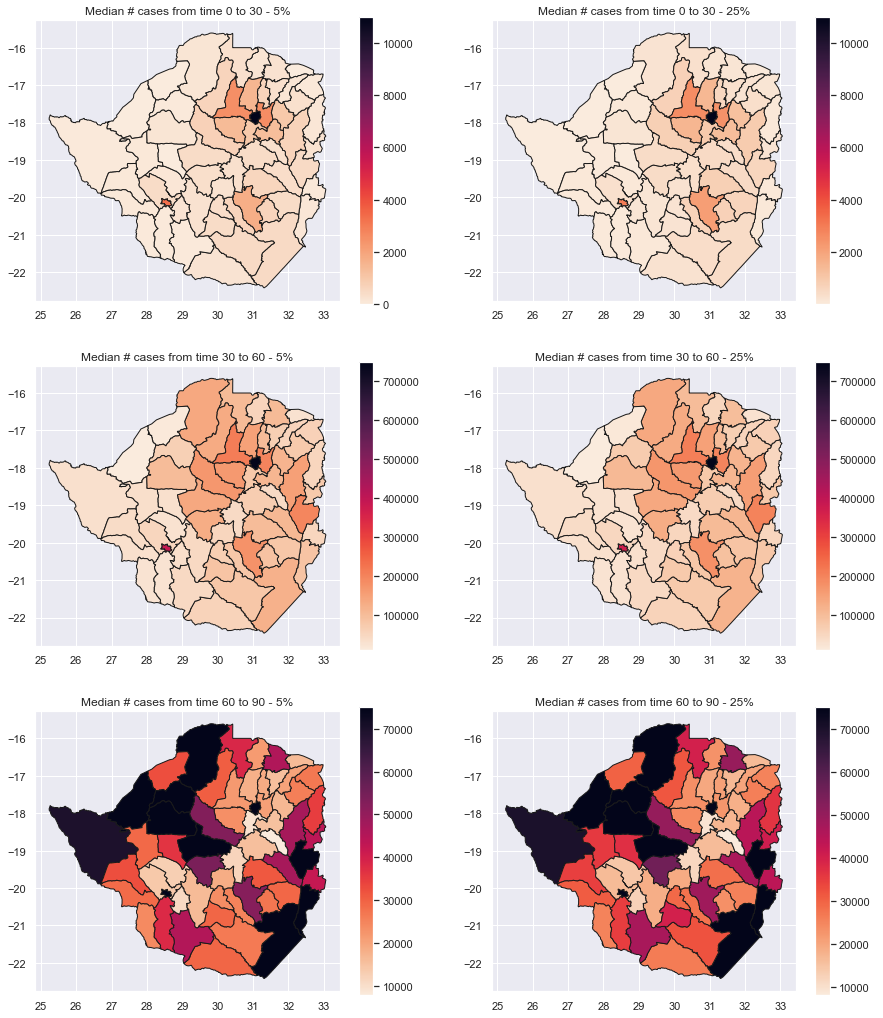

In [14]:
# set up the figure
fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 18) # change the plot size
sns.set(font_scale=1) # change the font size

index = 1

axlast = []
maxFriend = [30000, 1000000, 150000]
maxIndex = 0

def plotOne(files, spatialDf, prefix, weight, time, title='Default', cmapMax=1000000):
    df = readInScenario(files, prefix, lowerTimeLimit = time - 30, upperTimeLimit = time)
    
    r_data = df.groupby('district', as_index=False).agg({'metric_died_count': 'median', 'metric_new_hospitalized': 'median', 
                                    'metric_new_critical': 'median', 'metric_new_cases_asympt': 'median',
                                    'metric_new_cases_sympt': 'median', 'metric_new_deaths': 'median', 
                                    'metric_new_recovered': 'median', 'metric_currently_infected': 'median'})

    # weight and adjust data
    for i in ['metric_died_count', 'metric_new_hospitalized', 'metric_new_critical',
                  'metric_new_cases_asympt', 'metric_new_cases_sympt',
                  'metric_new_deaths', 'metric_new_recovered', 'metric_currently_infected']:
        r_data[i] = r_data[i] * weight

    joined = spatialDf.join(r_data.set_index("district"), on="ID_2", how="left")
    joined['metric_new_cases'] = (joined['metric_new_cases_sympt'] + joined['metric_new_cases_asympt'])
    
    joined.plot(ax = axlast, column='metric_new_cases', cmap='rocket_r', edgecolor='k', legend=True, vmax=cmapMax)
    plt.title("Median # cases from time " + str(time-30) + " to " + str(time) + " - " + title)
    return joined

#limitFriends = [10, 150, 2500]
limitFriends = [11000, 750000, 75000] 
limitIndex = 0

for i in [30, 60, 90]:
    axlast = plt.subplot(3, 2, index)
    index += 1
    plotOne(files, zimbabwe, prefix_v3_5, 20, i, "5%", cmapMax=limitFriends[limitIndex])

    axlast = plt.subplot(3, 2, index)
    index += 1
    plotOne(files, zimbabwe, prefix_v3_25, 4, i, "25%", cmapMax=limitFriends[limitIndex])

    limitIndex += 1

In [15]:
zimbabwe

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,256,ZWE,Zimbabwe,1,Bulawayo,1,Bulawayo,District,District,None,None,"POLYGON ((28.61305 -20.23587, 28.60440 -20.225..."
1,256,ZWE,Zimbabwe,2,Harare,2,Harare,District,District,None,Salisbury|Harare Urban,"POLYGON ((31.08852 -17.66625, 31.11038 -17.667..."
2,256,ZWE,Zimbabwe,3,Manicaland,3,Buhera,District,District,None,None,"POLYGON ((32.39763 -19.76925, 32.39830 -19.780..."
3,256,ZWE,Zimbabwe,3,Manicaland,4,Chimanimani,District,District,None,None,"POLYGON ((33.01395 -20.01098, 33.01094 -20.018..."
4,256,ZWE,Zimbabwe,3,Manicaland,5,Chipinge,District,District,None,None,"POLYGON ((32.42310 -21.06366, 32.40906 -21.078..."
5,256,ZWE,Zimbabwe,3,Manicaland,6,Makoni,District,District,None,None,"POLYGON ((31.98373 -19.11975, 31.98071 -19.108..."
6,256,ZWE,Zimbabwe,3,Manicaland,7,Mutare,District,District,None,Umtali,"POLYGON ((32.77855 -19.37489, 32.77308 -19.375..."
7,256,ZWE,Zimbabwe,3,Manicaland,8,Mutasa,District,District,None,None,"POLYGON ((32.44506 -18.39830, 32.45688 -18.392..."
8,256,ZWE,Zimbabwe,3,Manicaland,9,Nyanga,District,District,None,None,"POLYGON ((32.99868 -18.20377, 32.99176 -18.203..."
9,256,ZWE,Zimbabwe,4,Mashonaland Central,10,Bindura,District,District,None,None,"POLYGON ((31.40236 -16.83971, 31.40105 -16.853..."


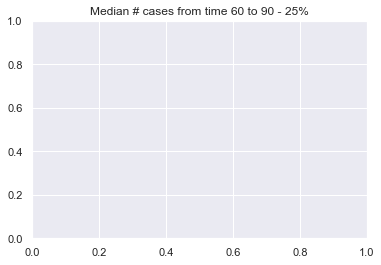

In [16]:
joined1 = plotOne(files, zimbabwe, prefix_v3_5 + '10.', 20, 90, "5%")
joined2 = plotOne(files, zimbabwe, prefix_v3_25 + '10.', 4, 90, "25%")


In [17]:
joined2.sort_values(by="metric_died_count")

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,geometry,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,metric_new_cases
28,256,ZWE,Zimbabwe,6,Mashonaland West,29,Kariba,District,District,None,...,"POLYGON ((28.25459 -17.39825, 28.24942 -17.391...",72,1060,220,10100,15652,72,45920,403368,25752
39,256,ZWE,Zimbabwe,8,Matabeleland North,40,Bubi,District,District,None,...,"POLYGON ((29.22650 -19.48012, 29.22359 -19.488...",100,868,244,3640,5628,100,32448,227440,9268
38,256,ZWE,Zimbabwe,8,Matabeleland North,39,Binga,District,District,None,...,"POLYGON ((28.08174 -17.84970, 28.08144 -17.851...",136,3092,756,32392,53352,136,93976,943280,85744
50,256,ZWE,Zimbabwe,9,Matabeleland South,51,Matobo,District,District,None,...,"POLYGON ((28.20738 -20.53341, 28.21135 -20.529...",188,2232,648,14580,26128,184,62844,567916,40708
49,256,ZWE,Zimbabwe,9,Matabeleland South,50,Mangwe (South),District,District,None,...,"POLYGON ((28.20738 -20.53341, 28.20599 -20.534...",188,1668,500,11644,19448,184,50340,450276,31092
51,256,ZWE,Zimbabwe,9,Matabeleland South,52,Umzingwane,District,District,None,...,"POLYGON ((28.66857 -20.30021, 28.72248 -20.265...",204,1208,444,4516,7700,196,38064,309532,12216
44,256,ZWE,Zimbabwe,8,Matabeleland North,45,Umguza,District,District,None,...,"POLYGON ((28.66857 -20.30021, 28.65701 -20.284...",208,1612,448,6244,10380,204,52720,392032,16624
22,256,ZWE,Zimbabwe,5,Mashonaland East,23,Seke,District,District,None,...,"POLYGON ((30.75946 -18.52284, 30.75798 -18.514...",216,1440,348,3660,5940,196,53036,453536,9600
45,256,ZWE,Zimbabwe,9,Matabeleland South,46,Beitbridge,District,District,None,...,"POLYGON ((31.08549 -22.34456, 31.07606 -22.343...",216,1888,508,8928,14956,212,71160,553840,23884
40,256,ZWE,Zimbabwe,8,Matabeleland North,41,Hwange,District,District,None,...,"POLYGON ((27.46796 -18.43833, 27.47824 -18.438...",220,2404,564,22284,39536,216,97892,885208,61820


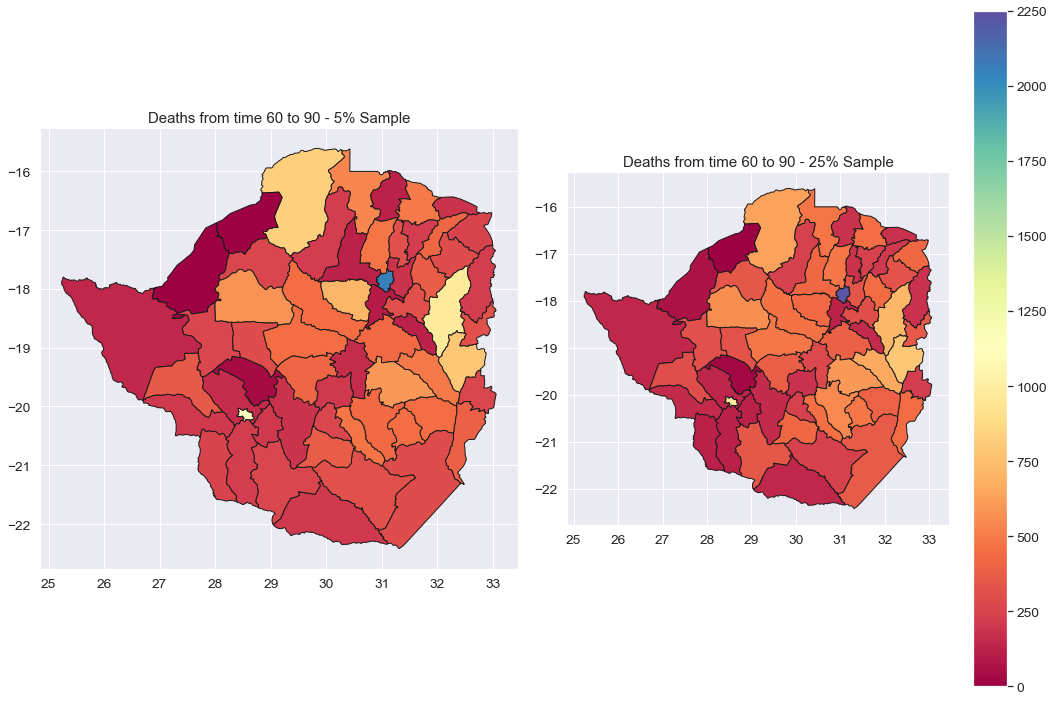

In [18]:
myMet = "metric_new_deaths"
joined1['death_diff'] = (joined2[myMet] - joined1[myMet]) / joined1[myMet]

# set up the figure
fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 10) # change the plot size
sns.set(font_scale=1.25) # change the font size

axlast = plt.subplot(1, 2, 1)
joined1.plot(ax=axlast, column='metric_new_deaths', cmap='Spectral', edgecolor='k', vmax=2250)
plt.title("Deaths from time 60 to 90 - 5% Sample")

axlast = plt.subplot(1, 2, 2)
sm = joined2.plot(ax=axlast, column='metric_new_deaths', cmap='Spectral', edgecolor='k', vmax=2250)
plt.title("Deaths from time 60 to 90 - 25% Sample")

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=2250))
fig.colorbar(sm)


# modify the layout
plt.tight_layout()

fig.savefig(path + "comparisonOfDeathsOverTime.png", dpi=300)

In [19]:
for i in [30, 60, 90]:
    
    df = readInScenario(files, prefix_v3_5, lowerTimeLimit = i - 30, upperTimeLimit = i)

    r_data = df.groupby('district', as_index=False).agg({'metric_died_count': 'median', 'metric_new_hospitalized': 'median', 
                                    'metric_new_critical': 'median', 'metric_new_cases_asympt': 'median',
                                    'metric_new_cases_sympt': 'median', 'metric_new_deaths': 'median', 
                                    'metric_new_recovered': 'median', 'metric_currently_infected': 'median'})

    # plot!
    axlast = plt.subplot(3, 2, index)
    index += 1

    joined = zimbabwe.join(r_data.set_index("district"), on="ID_1")
    joined['metric_new_cases'] = 20 * (joined['metric_new_cases_sympt'] + joined['metric_new_cases_asympt'])
    joined.plot(ax = axlast, column='metric_died_count', cmap='rainbow', edgecolor='k', legend=True)#, vmax=maxFriend[maxIndex])
    plt.title("Median # cases from time " + str(i-30) + " to " + str(i) + " - 5%")
    
    df = readInScenario(files, prefix_v3_25, lowerTimeLimit = i - 30, upperTimeLimit = i)

    r_data = df.groupby('district', as_index=False).agg({'metric_died_count': 'median', 'metric_new_hospitalized': 'median', 
                                    'metric_new_critical': 'median', 'metric_new_cases_asympt': 'median',
                                    'metric_new_cases_sympt': 'median', 'metric_new_deaths': 'median', 
                                    'metric_new_recovered': 'median', 'metric_currently_infected': 'median'})

    # plot!
    axlast = plt.subplot(3, 2, index)
    index += 1

    joined = zimbabwe.join(r_data.set_index("district"), on="ID_1")
    joined['metric_new_cases'] = 4 * (joined['metric_new_cases_sympt'] + joined['metric_new_cases_asympt'])
    joined.plot(ax = axlast, column='metric_died_count', cmap='rainbow', edgecolor='k', legend=True)#, vmax=maxFriend[maxIndex])
    plt.title("Median # cases from time " + str(i-30) + " to " + str(i) + " - 25%")
    
    maxIndex += 1
    
# save the figure
fig.savefig(path + "caseCounts_mapOverTime.png", dpi=300)

ValueError: num must be 1 <= num <= 6, not 7

<Figure size 432x288 with 0 Axes>

In [ ]:




def plotMapAtTimeFromDF(df, geoDf, geoDfColname="ID_1", weighting=1, days=30): # add time cutoff -how many days?

    #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
    unique_dist_names = pd.unique(df['myId'])
    df_raw = df[df["time"] < days]
    
    if len(unique_dist_names) == 1:
        return
    else:

        distNum = [int(x.split('_')[1]) for x in r_data['myId']]
        r_data[geoDfColname] = distNum
        #print(r_data.head())
        #print(geoDf.head())
        for i in ['metric_died_count', 'metric_new_hospitalized', 'metric_new_critical',
                  'metric_new_cases_asympt', 'metric_new_cases_sympt',
                  'metric_new_deaths', 'metric_new_recovered', 'metric_currently_infected']:
            r_data[i] = r_data[i] * weighting

        return joined


In [ ]:
fig = plt.figure()

data = v3Files_5
weighting = 20

fig, axs = plt.subplots(nrows=len(data), figsize=(10,40))

for i in range(len(data)):
    x = plotMapAtTime(path + data[i], zimbabwe, weighting=weighting, days=60)
    x.plot(ax=axs[i], column='metric_died_count', cmap='OrRd', edgecolor='k', legend=True)
    #ax.title(v3Files_5[i])

fig.savefig(path + "5_results.png", dpi=300)

## Other things

In [ ]:
prefix = "myriad_test_agg_5p_" # _v1


fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 8) # change the plot size
sns.set(font_scale=2) # change the font size
    
params = ["m1_", "v1_", "v3_"]
my5Style = "-"
colors = ['b', 'y', 'g']
for i in range(len(params)):
    plotMetric(files, prefix + params[i], ["metric_new_deaths"], colors[i] + my5Style, .3, 20, params[i], days=90)



prefix = "myriad_test_agg_25p_" # _v1    
my25Style = "--"
for i in range(len(params)):
    plotMetric(files, prefix + params[i], ["metric_new_deaths"], colors[i] + my25Style, 1, 4, params[i], days=90)


#plt.legend(params)

#plt.savefig(path + "1DistNoWknds_beta_comps_90days.png", dpi=300)

In [ ]:
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/myriadOutputs/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)



fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 8) # change the plot size
sns.set(font_scale=2) # change the font size
    
params = ["m1_", "v1_", "v3_"]
my5Style = "-"
colors = ['b', 'y', 'g']
dayLimit = 10
metrics = ["metric_new_cases_sympt", "metric_new_cases_asympt"]

prefix = "myriad_test_agg_5p_" # _v1    
x = plotMetric(files, prefix + "m1_0.3_8_", metrics, 'b' + my5Style, 1, 20, "m1", days=dayLimit)
x = plotMetric(files, prefix + "v1_0.3_8_", metrics, 'y' + my5Style, 1, 20, "v1", days=dayLimit)
x = plotMetric(files, prefix + "v3_0.3_8_", metrics, 'g' + my5Style, 1, 20, "v3", days=dayLimit)

prefix = "myriad_test_agg_25p_" # _v1    
x = plotMetric(files, prefix + "m1_0.3_8_", metrics, 'b' + my25Style, 1, 4, "m1", days=dayLimit)
x = plotMetric(files, prefix + "v1_0.3_8_", metrics, 'y' + my25Style, 1, 4, "v1", days=dayLimit)
x = plotMetric(files, prefix + "v3_0.3_8_", metrics, 'g' + my25Style, 1, 4, "v3", days=dayLimit)


In [ ]:
fig = plt.gcf() # extracting the figure information so we can change sizes
fig.set_size_inches(15, 8) # change the plot size
sns.set(font_scale=2) # change the font size

x = plotMetric(files, "myriad_test_agg_5p_" + "v1_", ["metric_new_deaths"], 'r-', .8, 20, "5%")
x = plotMetric(files, "myriad_test_agg_25p_" + "v1_", ["metric_new_deaths"], 'b--', .8, 4, "25%")

## Plot the geographies

In [ ]:
testing = v3Files_5[1]
print(testing)
x = plotMapAtTime(path + testing, zimbabwe, weighting=5)
x.plot(column='metric_new_deaths', cmap='OrRd', edgecolor='k', legend=True)
sum(x["metric_died_count"])
x

In [ ]:
testing = v3Files_25[1]
print(testing)
x = plotMapAtTime(path + testing, zimbabwe, weighting=1)
x.plot(column='metric_died_count', cmap='OrRd', edgecolor='k', legend=True)
sum(x["metric_died_count"])